In [1]:
import numpy as np
import pandas as pd
import cbsodata as cbs
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import time
import geopandas as gpd

# Define a path to save the Images to
if not os.path.exists("Images"):
    os.mkdir("Images")

# Regional data processing

In this section, a look is taken at what the effect on the region is on mode of choice behaviour and whether the region can have an effect on having a driver license. First, this is studied by analyzing the percentage of driver license holders per province of The Netherlands. After that, the travel mode behaviour is studied per region and per weekday. 

### Driver Licenses per Region

Firstly, all the different datasets are directly imported from the CBS with the packages obsodata, this can take a few minutes depending on the internet connection

In [2]:
#data_travel = pd.DataFrame(cbsodata.get_data('84713ENG'))
tic = time.perf_counter()
df_regio = pd.DataFrame(cbs.get_data('83488ENG')) # Insert dataset with Licenseholder data
tac = time.perf_counter()
print(f'Regional data is downloaded in {tac-tic:.2f} seconds : Progress is {1/3*100:.2f} %')

tic = time.perf_counter()
df_population = pd.DataFrame(cbs.get_data('37259ENG'))   # Insert dataset with population data
tac = time.perf_counter()
print(f'Population data is downloaded in {tac-tic:.2f} seconds : Progress is {2/3*100:.2f}%')

tic = time.perf_counter()
df_trips = pd.DataFrame(cbs.get_data('84708ENG')) # Insert dataset with trips values for different modes
tac = time.perf_counter()
print(f'Trips data is downloaded in {tac-tic:.2f} seconds : Progress is {3/3*100:.2f}%')

Regional data is downloaded in 4.22 seconds : Progress is 33.33 %
Population data is downloaded in 149.87 seconds : Progress is 66.67%
Trips data is downloaded in 33.71 seconds : Progress is 100.00%


Then the regio dataset is filtered for all the values we want to know 

In [3]:
# First, the region and years which will be looked at, are defined.

provinces = ['Groningen (PV)','Fryslân (PV)','Drenthe (PV)','Overijssel (PV)',
 'Flevoland (PV)','Gelderland (PV)','Utrecht (PV)','Noord-Holland (PV)',
 'Zuid-Holland (PV)','Zeeland (PV)','Noord-Brabant (PV)','Limburg (PV)'] # The regions which are selected

years = ['2014','2015','2016','2017','2018','2019','2020','2021'] # The years which are selected

# Then, new filtered DataFrames are created and the data which will be used is extracted from the downloaded datasets.

df_regio_filtered = df_regio[df_regio['CategoryDrivingLicence'] == 'Passenger car driving licence total']
df_regio_filtered = df_regio_filtered[df_regio_filtered['AgeDrivingLicenseHolder'] == 'Total']
df_regio_filtered = df_regio_filtered.loc[df_regio_filtered['Region'].isin(provinces)]
df_regio_filtered = df_regio_filtered.loc[df_regio_filtered['Periods'].isin(years)]

df_pop_filtered = df_population[df_population['Sex'] == 'Total male and female']
df_pop_filtered = df_pop_filtered[['Regions', 'Periods', 'PopulationOn31December_20']]
df_pop_filtered = df_pop_filtered.loc[df_pop_filtered['Regions'].isin(provinces)]
df_pop_filtered = df_pop_filtered.loc[df_pop_filtered['Periods'].isin(years)]

df_pop_filtered.reset_index(inplace = True)
df_regio_filtered.reset_index(inplace = True)

# The total population data is added to the regional dataset so that the percentage of driver license holders can be computed
# and also added to the Regional dataset

df_regio_filtered['Total_Population'] = df_pop_filtered['PopulationOn31December_20']
df_regio_filtered['Percentage'] = df_regio_filtered['PeopleWithADrivingLicence_1'] / df_regio_filtered['Total_Population'] * 100


Now the dataset is filtered, and the regional percentage figures can be plotted with GeoPandas. First the map is downloaded from PDOK and then the percentage is added to the geopandas dataset after which the regional data can be plotted. There are two figures shown to demonstrate the difference over the years.

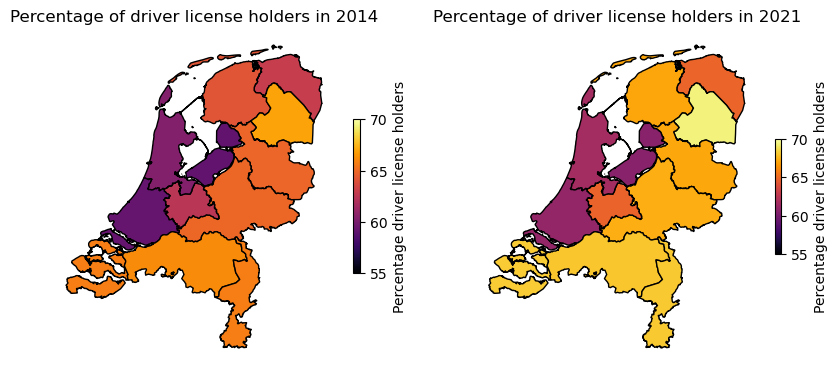

In [4]:
# Download the map from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_provincie_2021_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)

# Filter the data which will be plotted with GeoPandas

periods = ['2014', '2021' ]  # Define two periods which are looked at

for year in periods:
    df_geo = df_regio_filtered[df_regio_filtered['Periods'] == year]
    df_geo = df_geo.loc[df_geo['Region'].isin(provinces)]
    df_geo = df_geo.reset_index()
    gemeentegrenzen[f'Percentage_{year}'] = df_geo['Percentage']
    
# Plot the maps for both years
    
fig,(ax1,ax2) = plt.subplots(ncols = 2, figsize= (10,5), sharey = True)
gemeentegrenzen.plot(ax=ax1, column='Percentage_2014',cmap='inferno', edgecolor='k', legend=True, legend_kwds={'label': "Percentage driver license holders",
                        'orientation': "vertical", 'shrink': 0.4}, vmax=70, vmin = 55) #
ax1.axis('off')
ax1.set_title('Percentage of driver license holders in 2014');
gemeentegrenzen.plot(ax=ax2, column='Percentage_2021',cmap='inferno', edgecolor='k', legend=True, legend_kwds={'label': "Percentage driver license holders",
                        'orientation': "vertical", 'shrink': 0.3}, vmax=70, vmin = 55)
ax2.axis('off')
ax2.set_title('Percentage of driver license holders in 2021'); 
plt.savefig('Images/Percentage_driverlicense.png') #Save the figure

Above, two figure are presented both with the same information which is the percentage of driver license holders per province of The Netherlands. The left figure presents the data from 2014 and the figure on the right presents the data from 2021. The lighter the colour, the higher the percentages of driver license holders. From the figures, we can retrieve two findings. Firstly, the overall percentage of driver license holders in The Netherlands is increasing, as the figure on the right is lighter than the figure on the left. This is the case for all provinces. The second finding can be seen on both figures as well. The 'Randstad' region is much darker than the other parts of the country. There can be several explainations for this, but there are a lot more public transport opportunities in these areas compared to the rural areas in the north, east and south. Therefore, the people in the 'Randstad' region are less dependable on a car than people in the rest of the country 

### Trips per mode of travel per region

For the region characterisitcs of Public Transport use, only the years 2018 and 2019 are considered as this are the non-covid years which are available for data

In [5]:
# First, the modes and years which are looked at are defined
modes = ['Passenger car (driver)', 'Passenger car (passenger)', 'Train', 'Bus/metro'] # Add 'Total'
years = ['2018','2019']


# Then, again, the data is filtered

df_trips_filtered = df_trips[df_trips['TripCharacteristics'] == 'Total']
df_trips_filtered = df_trips_filtered.loc[df_trips_filtered['Margins'] == 'Value']
df_trips_filtered = df_trips_filtered[['ModesOfTravel', 'TripCharacteristics', 'RegionCharacteristics', 'Periods', 'Trips_1', 'Trips_4']]
df_trips_filtered = df_trips_filtered.loc[df_trips_filtered['RegionCharacteristics'].isin(provinces)]
df_trips_filtered = df_trips_filtered.loc[df_trips_filtered['Periods'].isin(years)]
df_trips_filtered = df_trips_filtered.loc[df_trips_filtered['ModesOfTravel'].isin(modes)]



-------------------------------------------------------------------------------------------------------------------------------


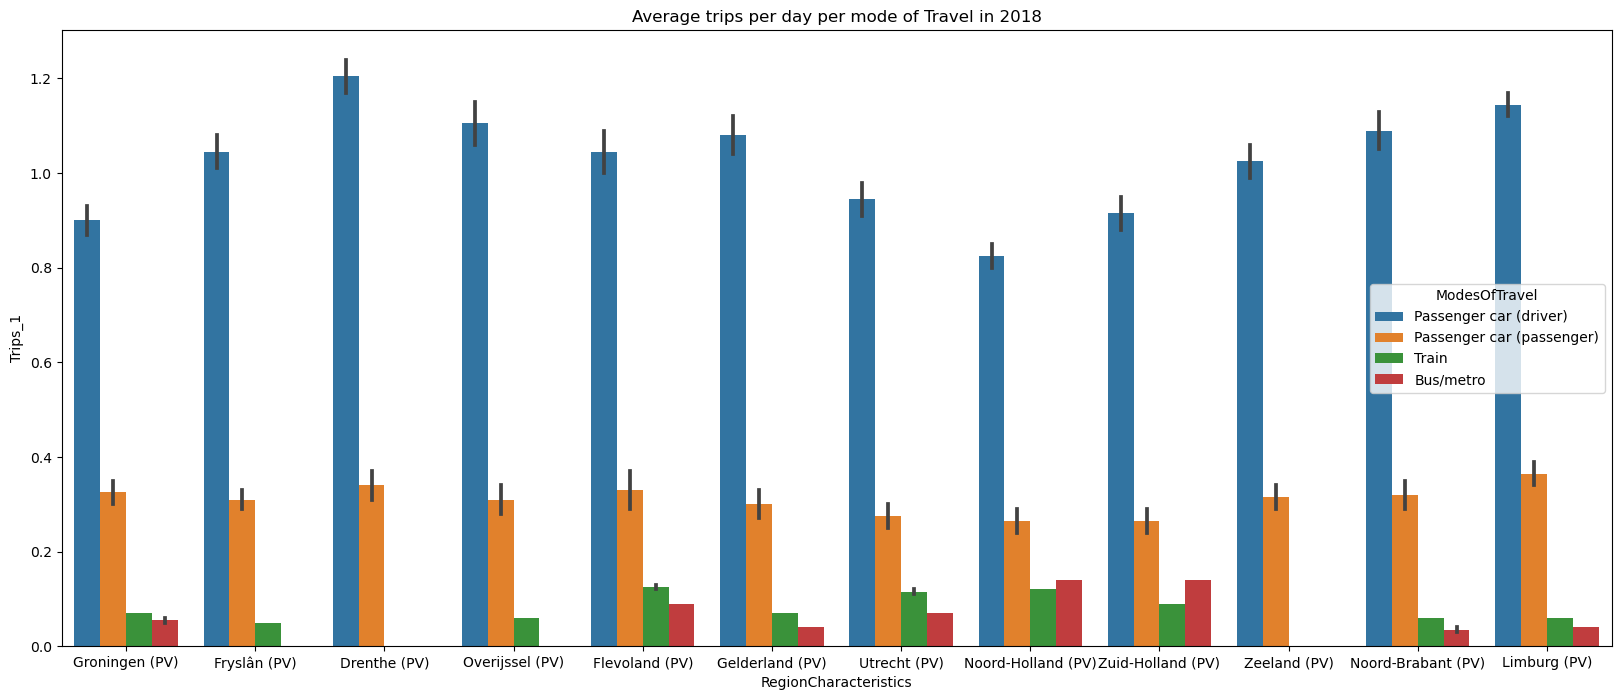

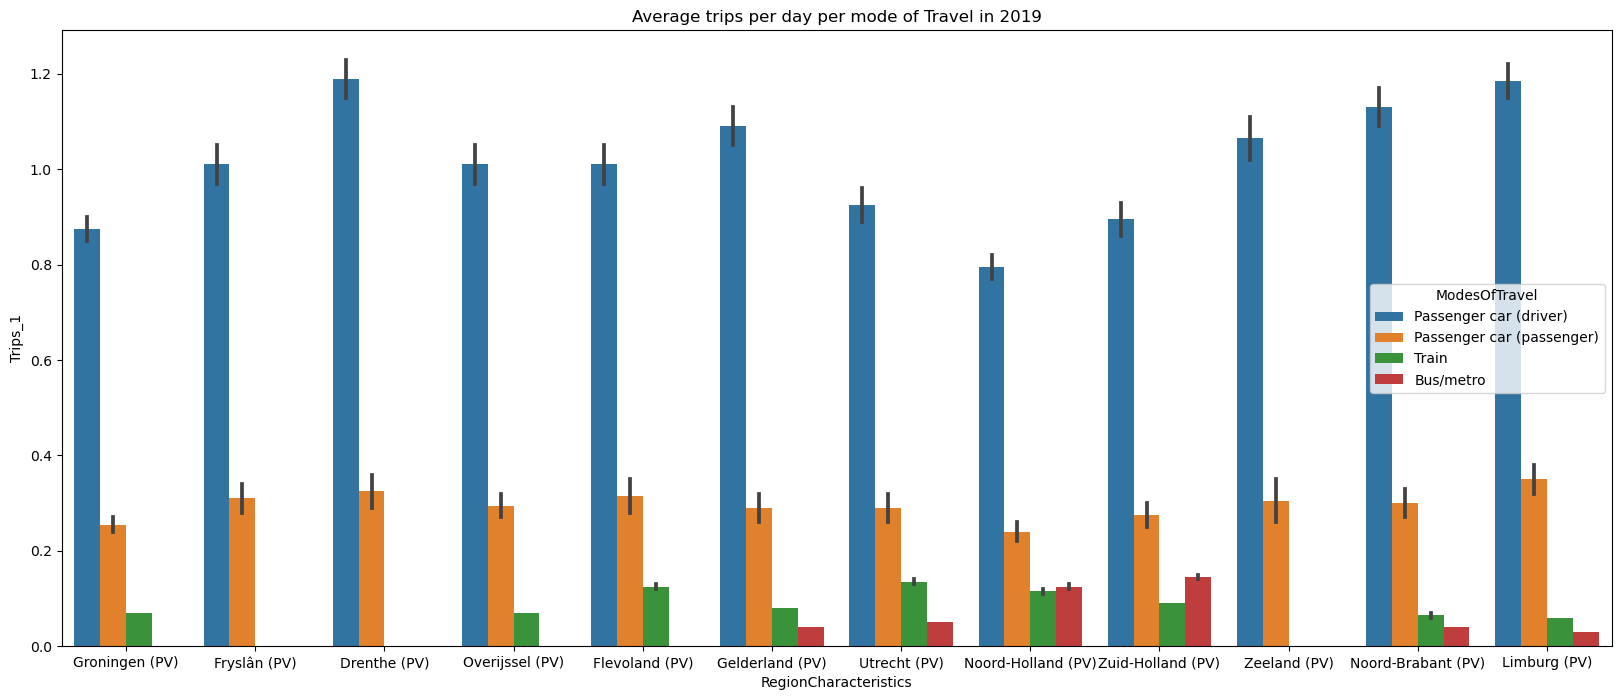

-------------------------------------------------------------------------------------------------------------------------------


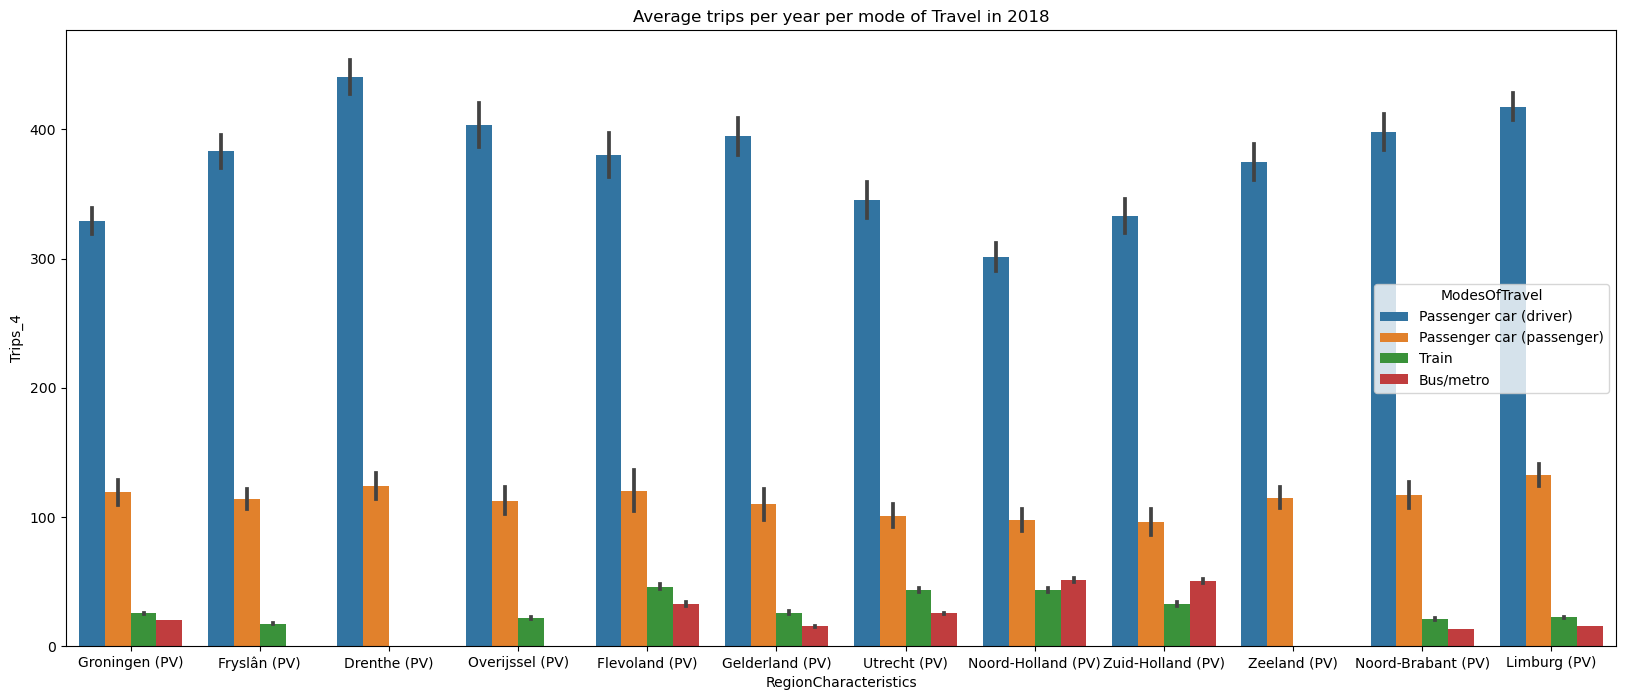

-------------------------------------------------------------------------------------------------------------------------------


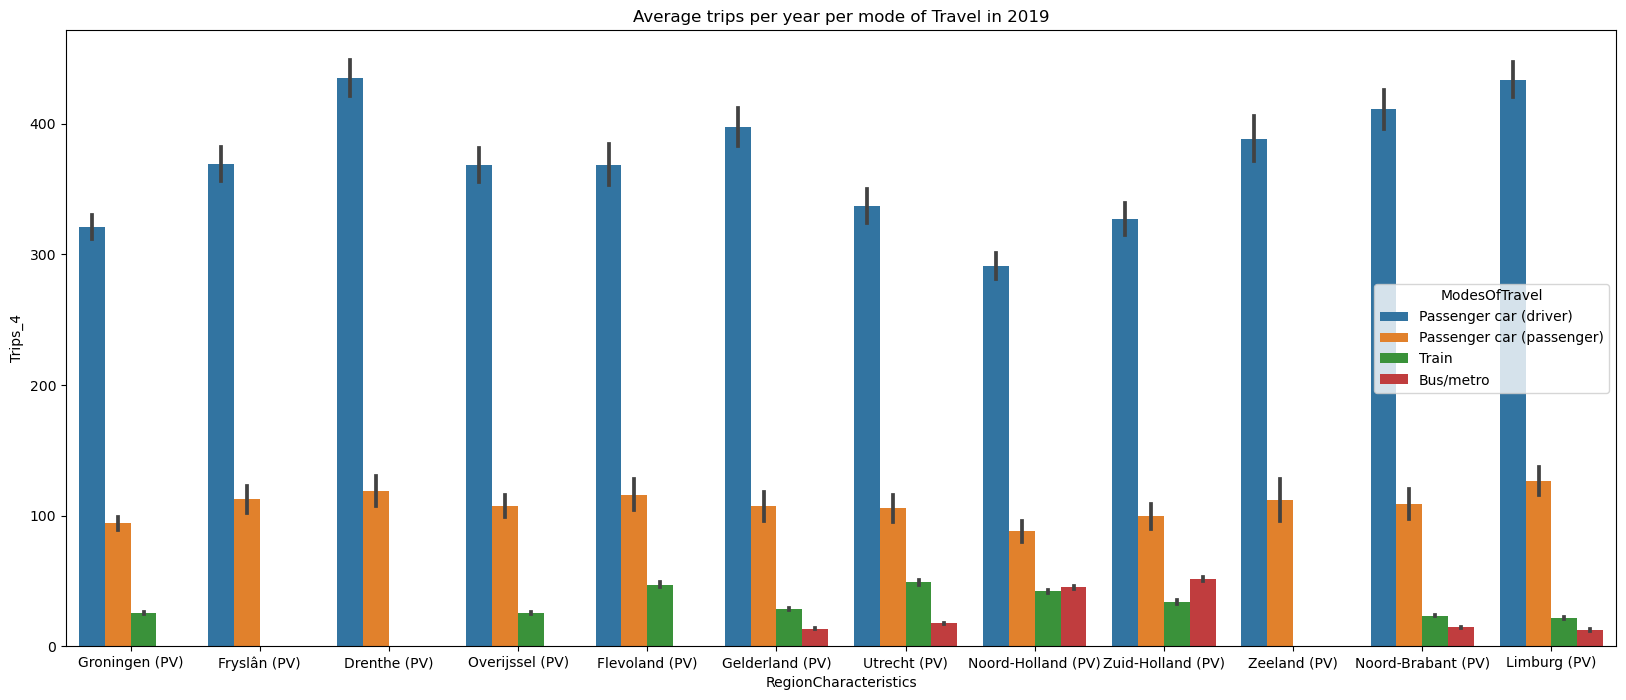

-------------------------------------------------------------------------------------------------------------------------------


In [6]:

print('-------------------------------------------------------------------------------------------------------------------------------')
for year in years:
    df = df_trips_filtered[df_trips_filtered['Periods'] == year]
    plt.figure(figsize = (20,8))
    sns_plot = sns.barplot(x= 'RegionCharacteristics', y= 'Trips_1', data = df, hue = 'ModesOfTravel')
    plt.title(f'Average trips per day per mode of Travel in {year}')
    sns_plot.figure.savefig(f'Images/Barplot{year}.png')
    plt.show()

print('-------------------------------------------------------------------------------------------------------------------------------')    
    
for year in years:
    df = df_trips_filtered[df_trips_filtered['Periods'] == year]
    plt.figure(figsize = (20,8))
    sns_plot = sns.barplot(x= 'RegionCharacteristics', y= 'Trips_4', data = df, hue = 'ModesOfTravel')
    plt.title(f'Average trips per year per mode of Travel in {year}')
    sns_plot.figure.savefig(f'Images/Total_trips_{year}.png')
    plt.show()
    print('-------------------------------------------------------------------------------------------------------------------------------')

From these plots, it is very clear that the regions which have more driver licenses on avarage, also have more car trips than average. This can be seen that the blue bar for Utrecht, Noord-Holland and Zuid-Holland are the lowest and for example Drenthe (the province with the highest percentage of driver license holders) has the most car trips. The bar plots above are relating to geoplot of the provinces in that case. <br>
Furthermore, the provinces Noord & Zuid Holland (Randstad) do also have a lot of public transport trips as this is very accessible in these regions. The bus and metro data in these areas is very high compared to other regions which mostly do not have a metroline at all.  

Sadly, there is some data missing from the public transport trips of Zeeland, Friesland en Drenthe to make a complete comparison


#### Comparison per week day

As this now is the trips per region, it can be helpfull to also take a look at the number of trips per day, to see whether the day of travel makes a difference. So first the data is filtered for each weekday and then the data is plotted in a boxplot to see what the values are for each day.

In [7]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
years = ['2018','2019']

df_week = df_trips.copy()

df_week = df_week.loc[df_week['TripCharacteristics'].isin(weekday)]
df_week = df_week.loc[df_week['Margins'] == 'Value']
df_week = df_week[['ModesOfTravel', 'TripCharacteristics', 'RegionCharacteristics', 'Periods', 'Trips_1', 'Trips_4']]
df_week = df_week.loc[df_week['RegionCharacteristics'].isin(provinces)]
df_week = df_week.loc[df_week['Periods'].isin(years)]
df_week = df_week.loc[df_week['ModesOfTravel'].isin(modes)]
df_week = df_week.dropna()


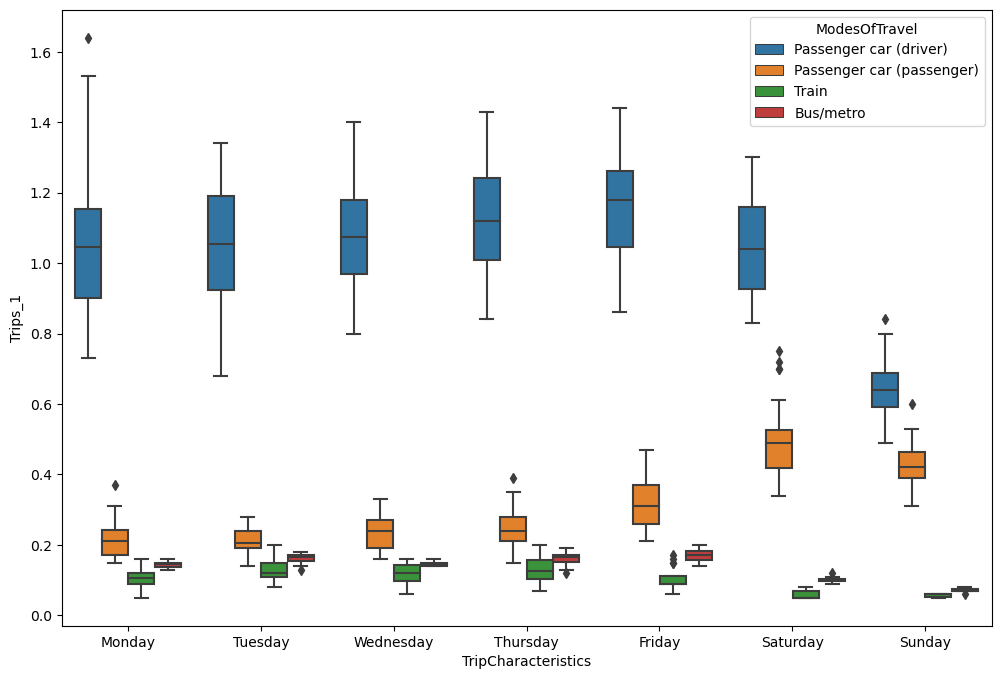

In [8]:
plt.figure(figsize = (12,8))
sns_plot1 = sns.boxplot(data = df_week, x = 'TripCharacteristics', y = 'Trips_1', hue = 'ModesOfTravel', order = weekday )
plt.savefig('Images/Boxplot')
plt.show()

From this, we can conclude that the regional data is very much relating to the weekdays as in these days the most trips are made in terms of public transport. The public transport trips on the weekdays are higher than in the weekends as less people travel to work then logically.<br>
On the other hand, regarding the car trips (driver) there is not much difference between a weekday and a saturday. There is between a weekday and a sunday however as the average trip on a sunday with a car is very low. <br>
On Saturday and Sunday however, the passenger trips in the car are much higher compared to weekdays. This can be seen that on weekends, more family or leisure trips are made generally instead of one person driving to work. 